In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, embedding_size, num_heads, ff_dim, dropout_rate):
        super(TransformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embedding_size, num_heads=num_heads, dropout=dropout_rate)
        self.norm1 = nn.LayerNorm(embedding_size)
        self.ffn = nn.Sequential(nn.Linear(embedding_size, ff_dim),
                                 nn.ReLU(),
                                 nn.Dropout(dropout_rate),
                                 nn.Linear(ff_dim, embedding_size))
        self.norm2 = nn.LayerNorm(embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        # Improved attention mechanism
        x_normalized = self.norm1(x)
        query = x_normalized
        key = x_normalized
        value = x_normalized
        attn_output, _ = self.attention(query, key, value, key_padding_mask=mask)
        attn_output = self.dropout(attn_output)
        attn_output = attn_output + x
        attn_output = self.norm2(attn_output)

        # Feedforward neural network
        ffn_output = self.ffn(attn_output)
        ffn_output = self.dropout(ffn_output)
        ffn_output = ffn_output + attn_output
        ffn_output = self.norm2(ffn_output)

        return ffn_output


class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_size, num_layers, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.pos_encoding = nn.Parameter(torch.zeros(1, 1000, embedding_size))
        self.transformer_blocks = nn.ModuleList([TransformerBlock(embedding_size, num_heads, ff_dim, dropout_rate) for _ in range(num_layers)])
        self.mlm_output = nn.Linear(embedding_size, vocab_size)
        self.mim_output = nn.Linear(embedding_size, embedding_size)
        self.wpa_output = nn.Linear(embedding_size, vocab_size)

    def forward(self, x, mask):
        x = self.embedding(x) + self.pos_encoding[:, :x.size(1), :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, mask)
        mlm_logits = self.mlm_output(x)
        mim_logits = self.mim_output(x)
        wpa_logits = self.wpa_output(x)
        return mlm_logits, mim_logits, wpa_logits



def mlm_loss_fn(logits, labels):
    loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
    loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
    return loss

def mim_loss_fn(logits, labels):
    loss = F.mse_loss(logits, labels)
    return loss

def wpa_loss_fn(logits, labels):
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)
    loss = loss_fn(logits.view(-1, logits.shape[-1]), labels.view(-1))
    return loss

class MLM(nn.Module):
    def __init__(self, vocab_size, hidden_size):
        super(MLM, self).__init__()
        self.embed = nn.Embedding(vocab_size, hidden_size)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, input_mask):
        embedded = self.embed(input_ids)
        masked_embedded = embedded.masked_fill(~input_mask.unsqueeze(-1), 0)
        masked_embedded_2d = masked_embedded.view(-1, masked_embedded.size(-1))
        logits_2d = self.linear(masked_embedded_2d)
        batch_size = masked_embedded.size(0)
        vocab_size = logits_2d.size(-1)
        logits_3d = logits_2d.view(batch_size, -1, vocab_size)
        return logits_3d



class MIM(nn.Module):
    def __init__(self, input_size):
        super(MIM, self).__init__()
        self.linear = nn.Linear(input_size, 32)

    def forward(self, input_tensor):
        return self.linear(input_tensor)


# Define the hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 1000

# Initialize the models and optimizer
mlm_model = MLM(vocab_size=10, hidden_size=64)
mim_model = MIM(input_size=10)

# Define the loss functions and optimizer
mlm_loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
mim_loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(list(mlm_model.parameters()) + list(mim_model.parameters()), lr=LEARNING_RATE)

In [13]:
train_data = [{"input": torch.LongTensor([2, 5, 3, 6, 1, 9, 7, 4, 8]),
               "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
               "mlm_output": torch.LongTensor([0, 0, 3, 0, 1, -100, 7, 0, 0]),
               "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
              },
              {"input": torch.LongTensor([7, 2, 1, 5, 4, 9, 6, 8, 3]),
               "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
               "mlm_output": torch.LongTensor([7, 0, 1, 0, 4, -100, 6, 3, 0]),
               "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
              }]

train_data += [    {"input": torch.LongTensor([1, 2, 3, 4, 5, 6, 7, 8, 9]),
     "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "mlm_output": torch.LongTensor([0, 0, 0, 0, 1, -100, 7, 0, 3]),
     "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
    },
    {"input": torch.LongTensor([9, 8, 7, 6, 5, 4, 3, 2, 1]),
     "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "mlm_output": torch.LongTensor([0, 0, 0, 0, 1, -100, 7, 0, 3]),
     "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
    },
    {"input": torch.LongTensor([3, 5, 2, 8, 4, 1, 6, 9, 7]),
     "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "mlm_output": torch.LongTensor([0, 0, 1, 0, 4, -100, 6, 3, 0]),
     "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
    },
    {"input": torch.LongTensor([6, 8, 4, 1, 5, 2, 3, 7, 9]),
     "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "mlm_output": torch.LongTensor([7, 0, 1, 0, 4, -100, 6, 3, 0]),
     "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
    },
    {"input": torch.LongTensor([4, 7, 2, 9, 3, 8, 1, 6, 5]),
     "mask": torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1]),
     "mlm_output": torch.LongTensor([0, 0, 0, 0, 1, -100, 7, 0, 3]),
     "mim_output": torch.FloatTensor([[0.5] * 32] * 9),
    }]

In [ ]:
mlm_model_path = "mlm_model.pt"
mim_model_path = "mim_model.pt"
# Train the models
for epoch in range(EPOCHS):
    mlm_model.train()
    mim_model.train()
    total_loss = 0
    for batch in train_data:
        input_ids = batch["input"]
        input_mask = batch["mask"]
        mlm_output = batch["mlm_output"]
        mim_output = batch["mim_output"]
        mlm_logits = mlm_model(input_ids, input_mask)
        mim_logits = mim_model(mlm_logits)
        mlm_loss = nn.CrossEntropyLoss(ignore_index=-100)(mlm_logits.view(-1, 10), mlm_output.view(-1))
        mim_loss = nn.MSELoss()(mim_logits, mim_output)
        loss = mlm_loss + mim_loss
        total_loss += loss.item()
        loss.backward()
        # Save the models after each epoch
    torch.save(mlm_model.state_dict(), mlm_model_path)
    torch.save(mim_model.state_dict(), mim_model_path)    
    print(f"Epoch {epoch+1}: Loss = {total_loss}")


In [ ]:
!pip install torchviz

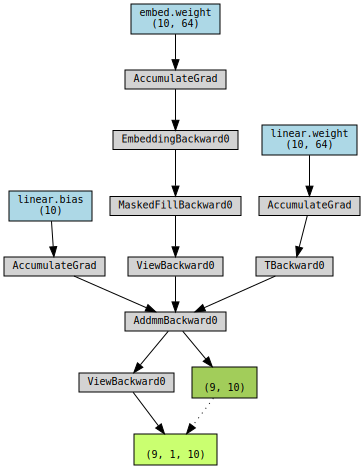

In [16]:
import torch
from torchviz import make_dot

# Define the input data
input_ids = torch.LongTensor([2, 5, 3, 6, 1, 9, 7, 4, 8])
input_mask = torch.BoolTensor([1, 1, 1, 1, 1, 1, 1, 1, 1])
sample_input = (input_ids, input_mask)

# Define the models
mlm_model = MLM(vocab_size=10, hidden_size=64)
mim_model = MIM(input_size=10)

# Generate the visualization of the MLM model
mlm_outputs = mlm_model(*sample_input)
make_dot(mlm_outputs, params=dict(mlm_model.named_parameters()))


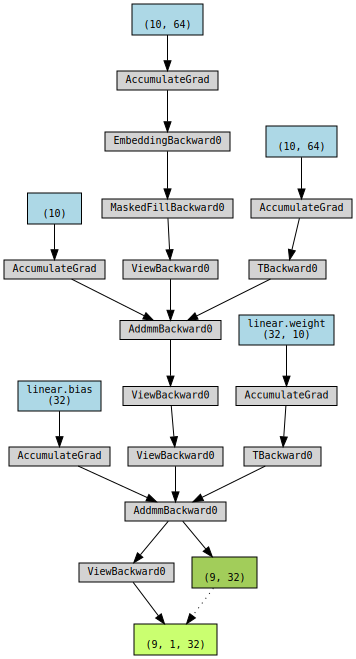

In [17]:
# Generate the visualization of the MIM model
mim_outputs = mim_model(mlm_outputs)
make_dot(mim_outputs, params=dict(mim_model.named_parameters()))